# How to build a QAOA ansatz with SWAP strategies

This how-to is a deep dive into the parametrized ansatz construction step of the QAOA workflow.

## Pre-Requisites

The QAOA ansatz is composed of a **cost operator** and a mixer **operator** applied in an alternating fashion to an **initial state**. In this example we fix the initial state and the mixer operator, and show how to build the ansatz for any cost operator, defined as a weighted sum of pauli terms.

For the sake of simplicity, we will import a pre-computed list of Paulis from a json file. These are generally extracted from the problem graph.

In [1]:
import json

graph_file = "data/graph_2layers_0seed.json"
data = json.load(open(graph_file, "r"))

local_correlators = data["paulis"]
print(local_correlators)

[['IIIIIZZIII', 1.0], ['IIIIIIZIZI', 1.0], ['IIIIIIZIIZ', 1.0], ['ZIIIIZIIII', 1.0], ['IIIIZZIIII', 1.0], ['IIZIIIIZII', 1.0], ['IZZIIIIIII', 1.0], ['IIZZIIIIII', 1.0], ['IIIIIIIZZI', 1.0], ['IIIIZIIZII', 1.0], ['IIIIZIIIIZ', 1.0], ['IIIIIIIIZZ', 1.0], ['ZZIIIIIIII', 1.0], ['IZIZIIIIII', 1.0], ['ZIIZIIIIII', 1.0]]


This list of Paulis can be used to build a sparse pauli operator:

In [2]:
from qiskit.quantum_info import SparsePauliOp

cost_operator = SparsePauliOp.from_list(local_correlators)
print(cost_operator)

SparsePauliOp(['IIIIIZZIII', 'IIIIIIZIZI', 'IIIIIIZIIZ', 'ZIIIIZIIII', 'IIIIZZIIII', 'IIZIIIIZII', 'IZZIIIIIII', 'IIZZIIIIII', 'IIIIIIIZZI', 'IIIIZIIZII', 'IIIIZIIIIZ', 'IIIIIIIIZZ', 'ZZIIIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


## 1. Build circuit for the cost operator Hamiltonian

The QAOA ansatz is composed of a series of alternating layers of cost operator unitary and mixer unitary blocks. We only want to apply the swap strategies to the cost operator layer, so we will start by creating the isolated block that we will later transform and append to the final QAOA circuit.

For this means, we can use the `QAOAAnsatz` class from Qiskit. We will input an empty circuit to the `initial_state` and `mixer_operator` fields to make sure we are buiding an isolated cost operator layer.

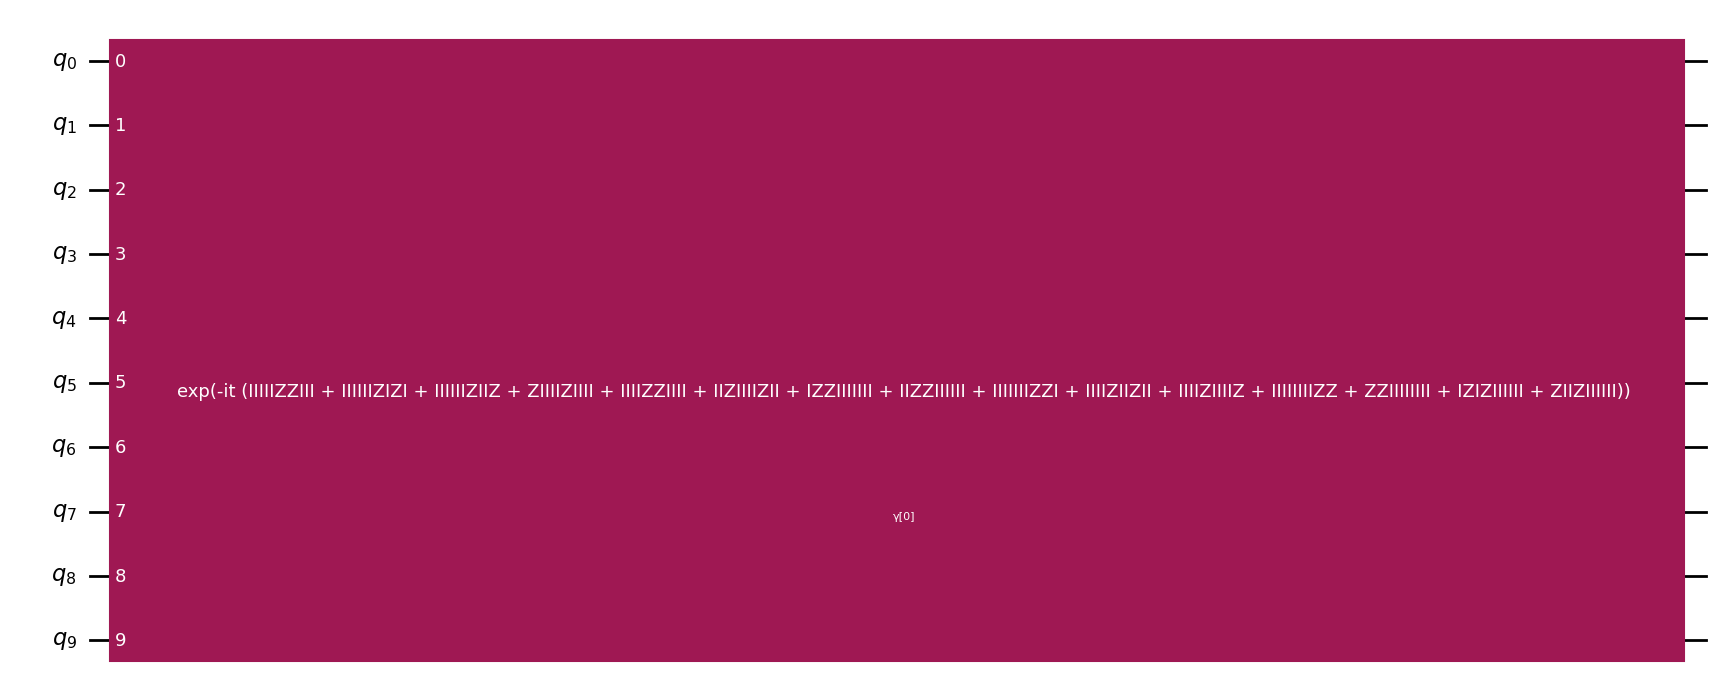

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz

num_qubits = cost_operator.num_qubits
dummy_initial_state = QuantumCircuit(num_qubits)  # the real initial state is defined later
dummy_mixer_operator = QuantumCircuit(num_qubits)  # the real mixer is defined later

cost_layer = QAOAAnsatz(
    cost_operator,
    reps=1,
    initial_state=dummy_initial_state,
    mixer_operator=dummy_mixer_operator,
    name="QAOA cost block",
).decompose()
cost_layer.draw("mpl")

The cost operator is composed of a series of parametrized RZZ gates, we can see this after decomposing the block:

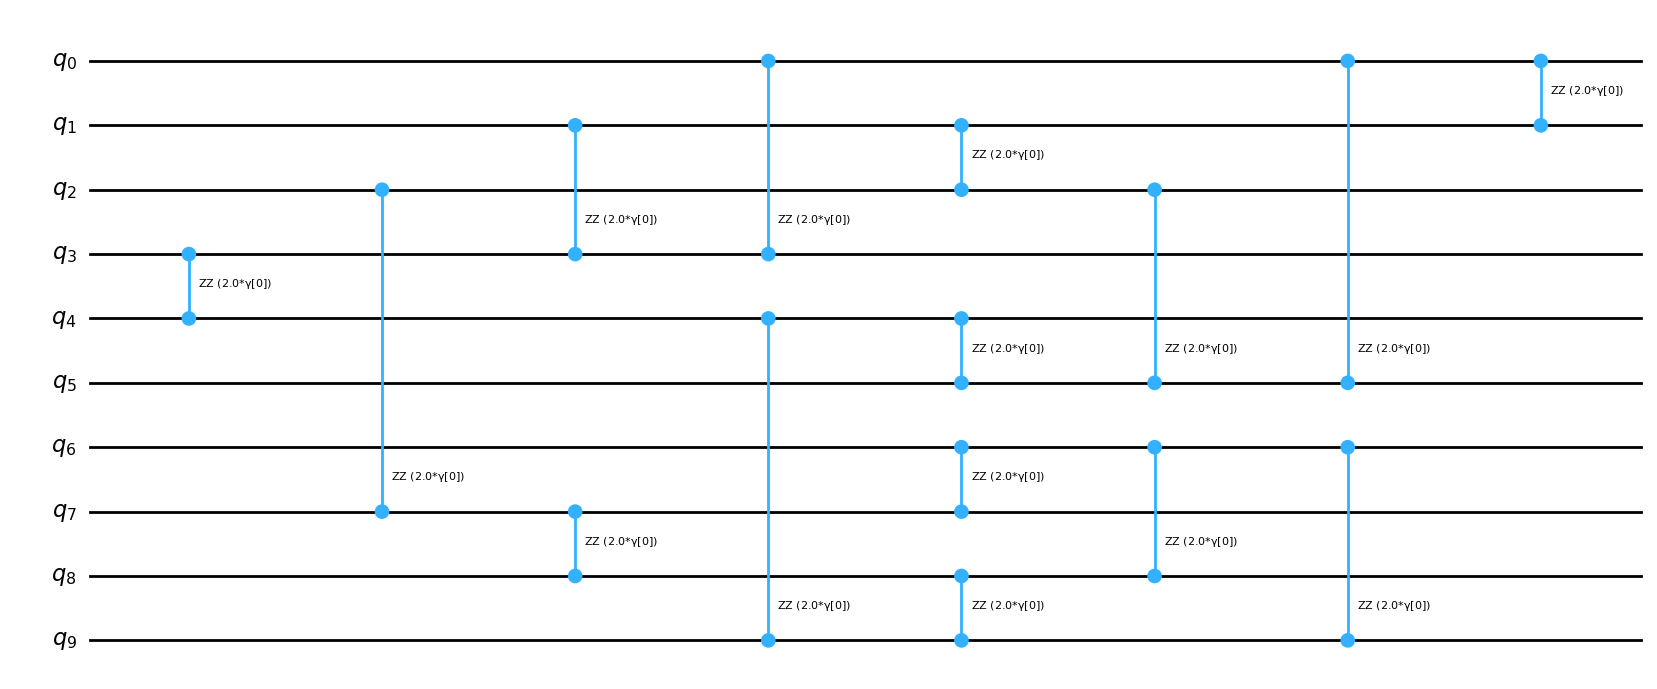

In [4]:
cost_layer.decompose(reps=2).draw("mpl")

If we decompose it again, we will see that these RZZ gates are built by combining RZ and CNOT gates.

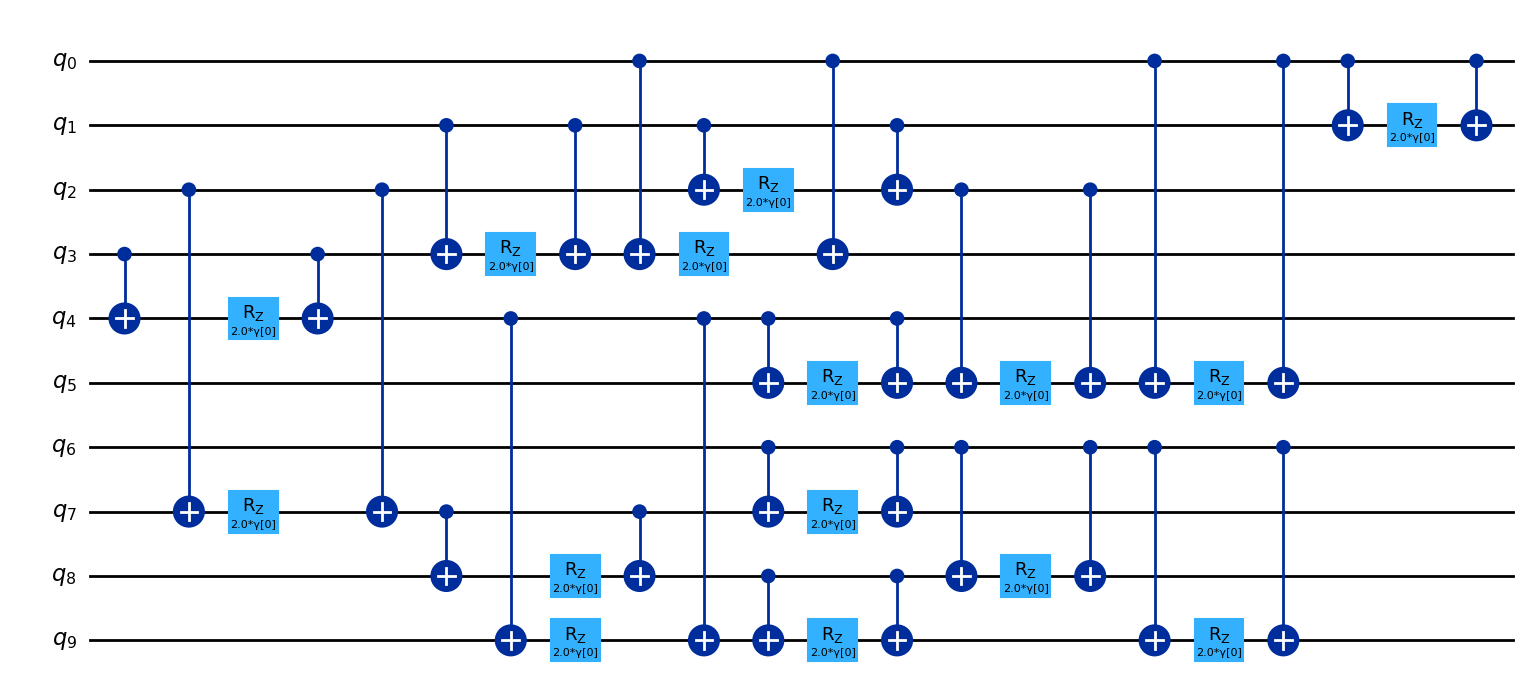

In [5]:
cost_layer.decompose(reps=3).draw("mpl")

Once we have defined our cost layer, we will add measurements to **all** qubits to allow us to keep track of the permutations introduced by the swap strategy.

In [6]:
cost_layer.measure_all()

## 2. Apply SWAP strategies

On this step, we will define a transpiler pass that applies a swap strategy for a given coupling map geometry (in this case, we will choose a line). We can use the `edge_coloring` parameter to group the commuting gates and optimize their placement. In this example, we define the `edge_coloring` map so that `RZZGate`s are positioned next to `SWAP` gates to exploit `CX` cancellations.

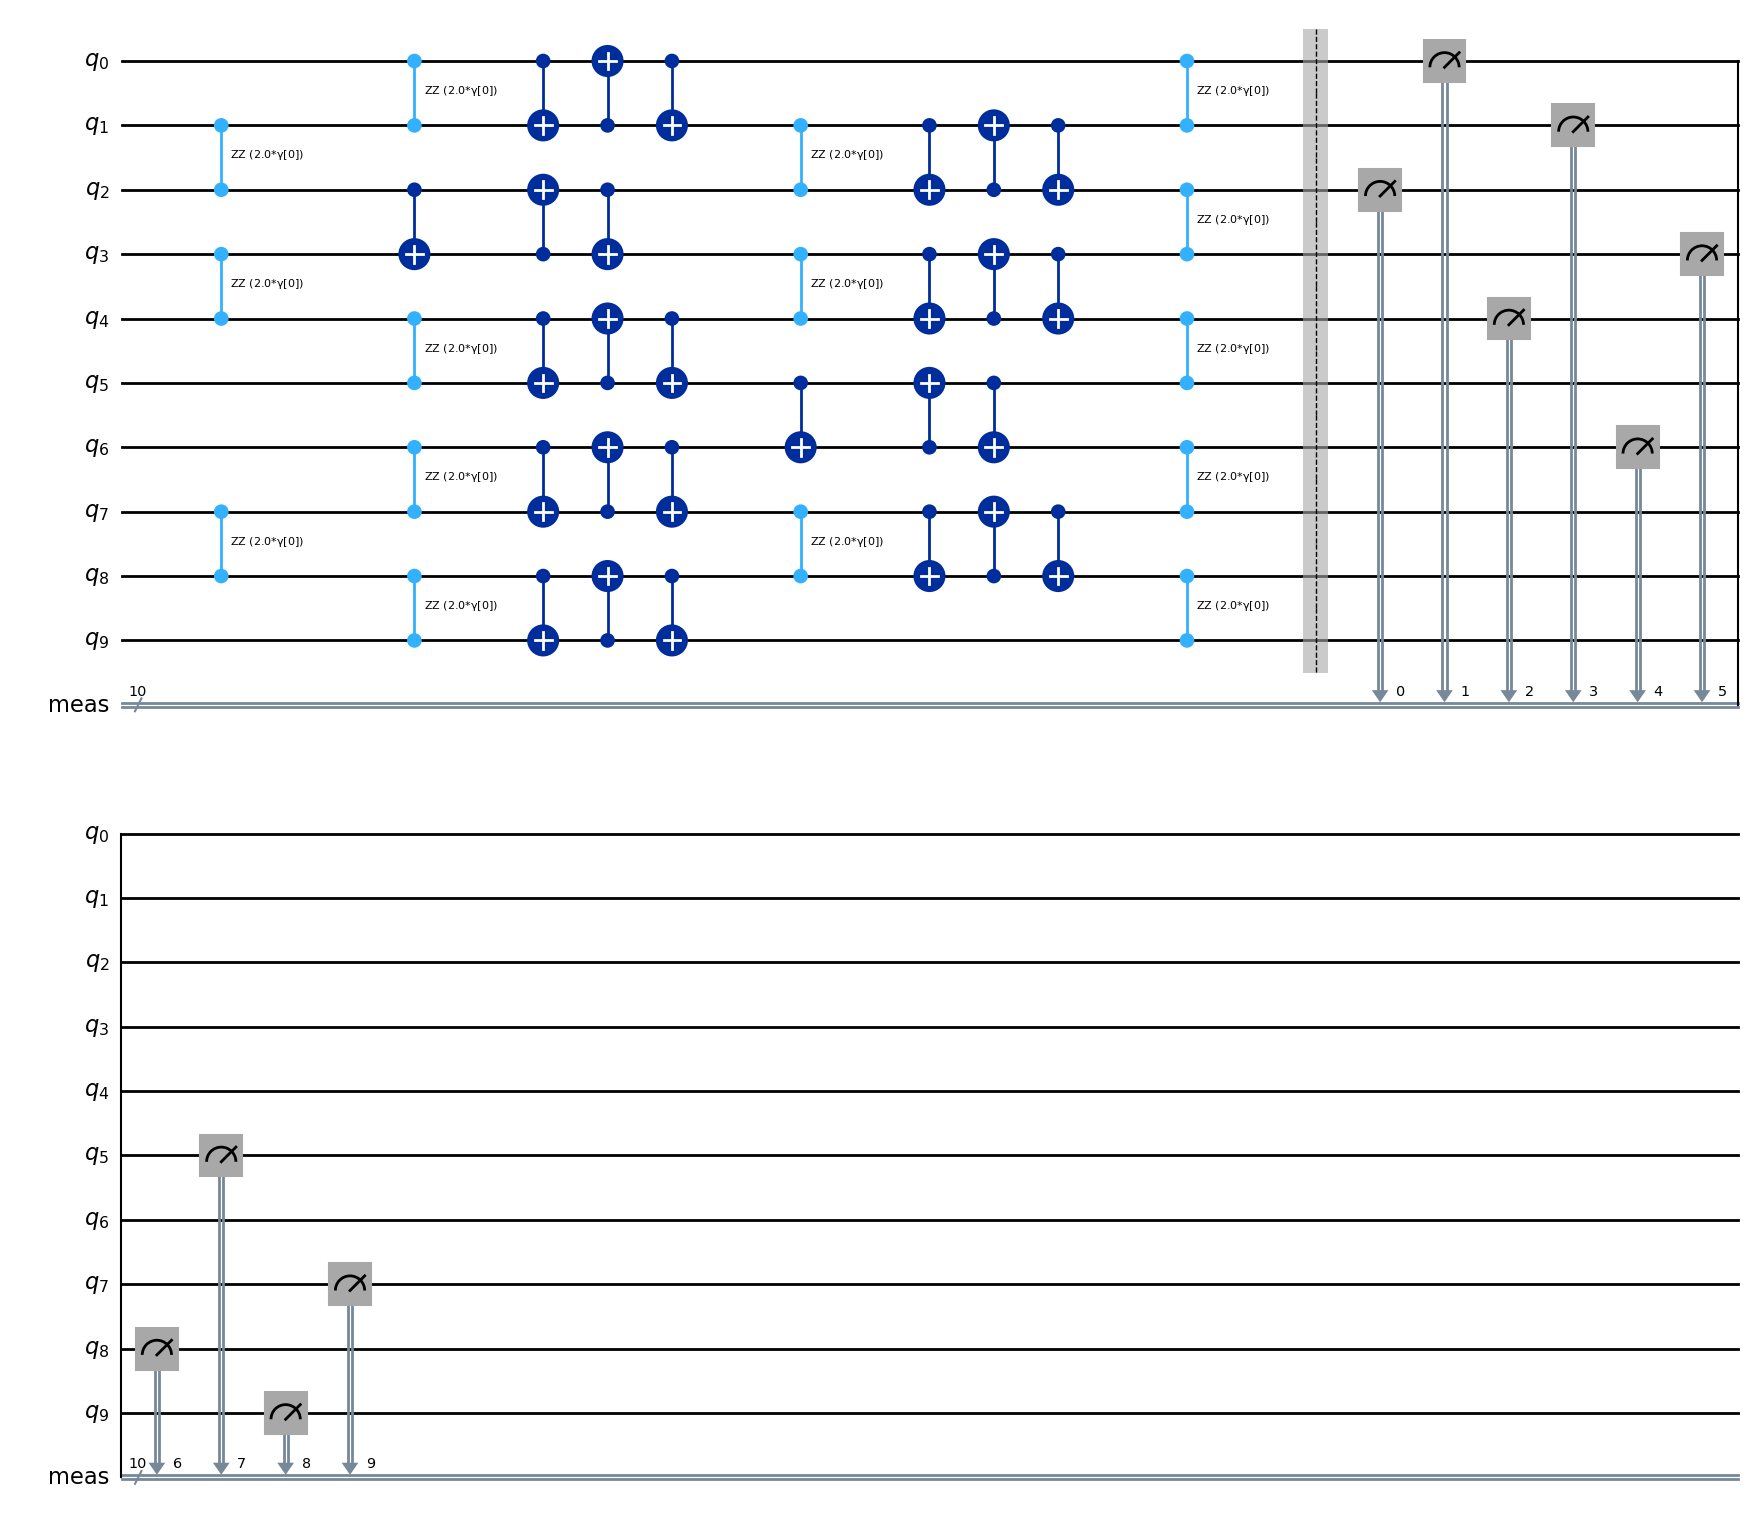

In [7]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)

# from qiskit.transpiler.passes import CommutativeCancellation

# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}


# 2. define Pass manager
pm_pre = PassManager(
    [
        FindCommutingPauliEvolutions(),
        Commuting2qGateRouter(
            swap_strategy,
            edge_coloring,
        ),
    ]
)

# 3. Run transpiler pass to apply swaps
swapped_cost_layer = pm_pre.run(cost_layer)
swapped_cost_layer.decompose().draw("mpl")

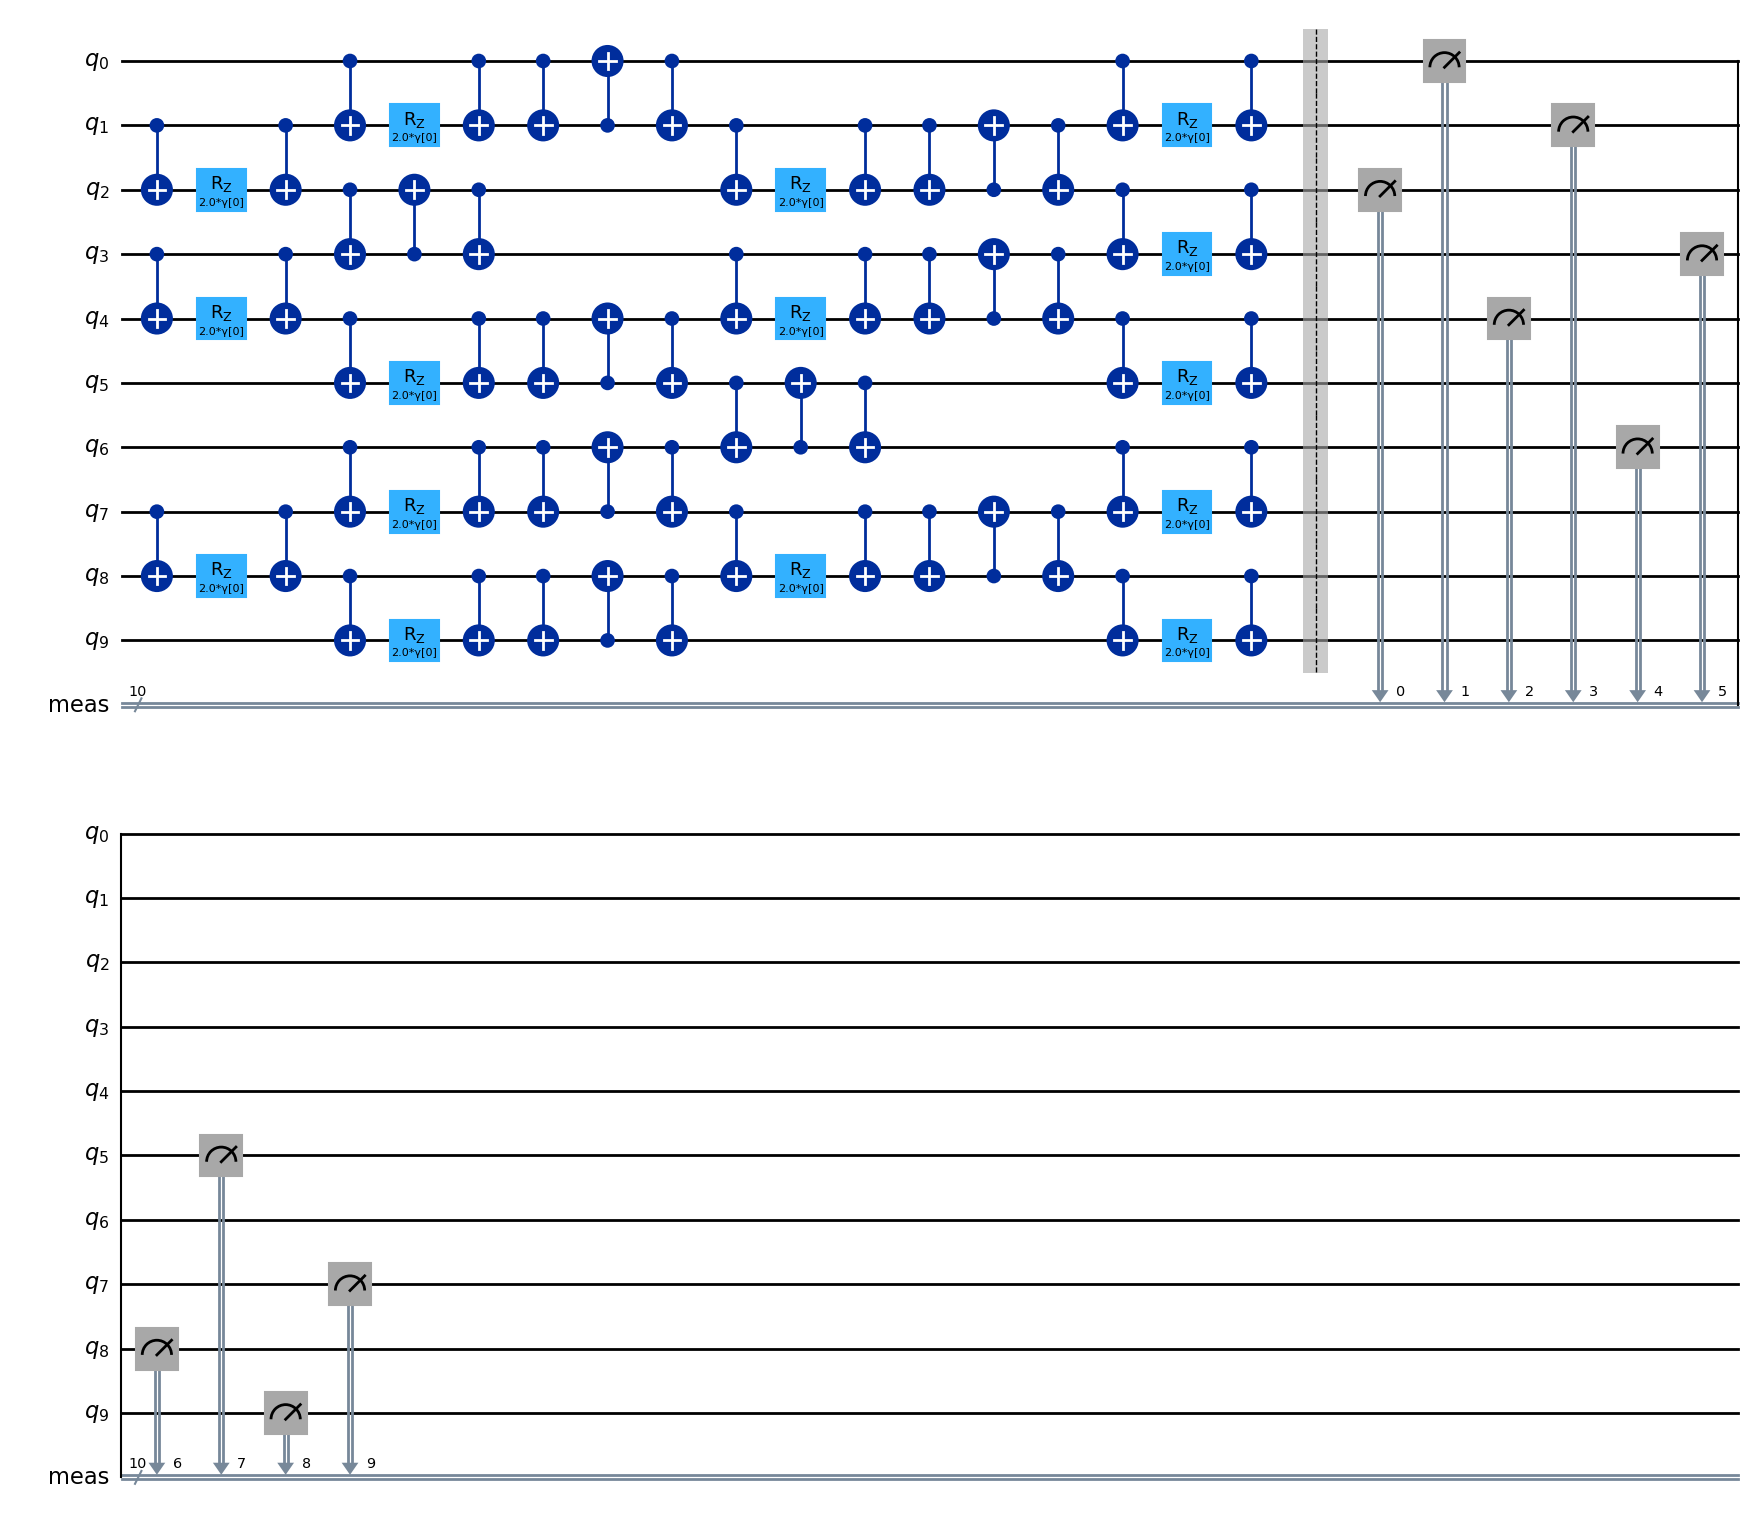

In [8]:
# Let's decompose the circuit to see it in terms of rzs and cnots

swapped_cost_layer.decompose(reps=2).draw("mpl")

## 3. Build measurement map to recover permutations

This steps depends on the number of QAOA layers we want our ansatz to contain (odd or even). We can use the `make_meas_map` helper class or build the mapping function ourselves.

In [9]:
from qopt_best_practices.swap_strategies import make_meas_map

# Compute the measurement map (qubit to classical bit).
# we will apply this for qaoa_layers % 2 == 1.

qaoa_layers = 2

if qaoa_layers % 2 == 1:
    meas_map = make_meas_map(swapped_cost_layer)
else:
    meas_map = {idx: idx for idx in range(num_qubits)}

We can now remove the measurements we previously introduced to keep up with the permutations.

In [10]:
swapped_cost_layer.remove_final_measurements()

## 4. Build final QAOA circuit alternating cost layers, permuted cost layers and mixer layers

In [11]:
swapped_cost_layer.parameters

ParameterView([ParameterVectorElement(γ[0])])

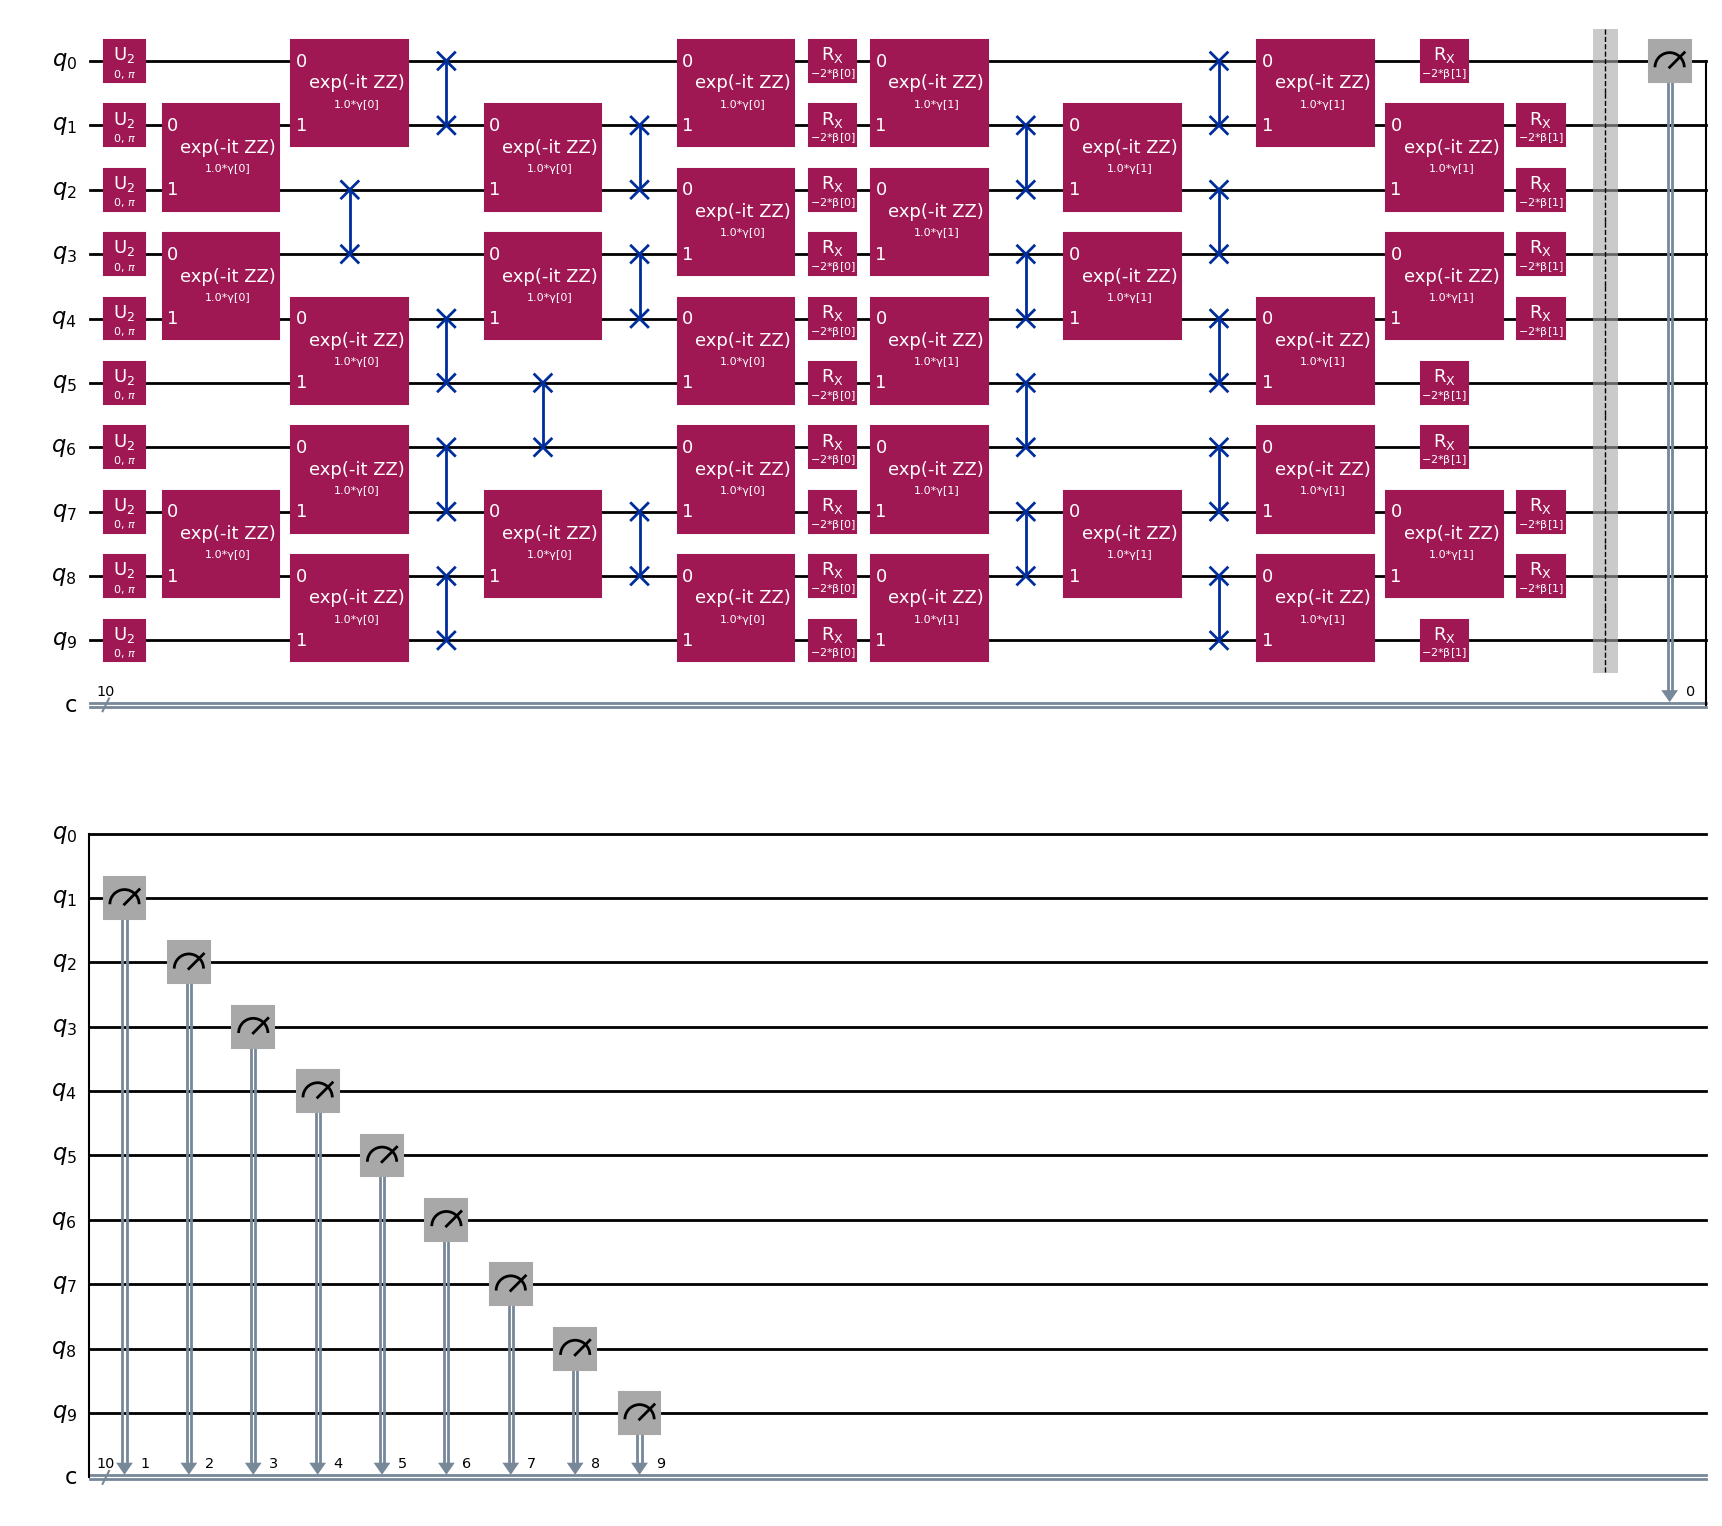

In [12]:
from qiskit.circuit import ParameterVector, Parameter

qaoa_circuit = QuantumCircuit(num_qubits, num_qubits)

# add here initial state, in this case --> all H
qaoa_circuit.h(range(num_qubits))

# create a gamma and beta parameter per layer
gammas = ParameterVector("γ", qaoa_layers)
betas = ParameterVector("β", qaoa_layers)

# define mixer layer, in this case --> rx
mixer_layer = QuantumCircuit(num_qubits)
mixer_layer.rx(-2*betas[0], range(num_qubits))

# iterate over number of qaoa layers
for layer in range(qaoa_layers):
    # assign parameters corresponding to layer
    cost = swapped_cost_layer.assign_parameters({swapped_cost_layer.parameters[0]: gammas[layer]})
    mixer = mixer_layer.assign_parameters({mixer_layer.parameters[0]: betas[layer]})

    if layer % 2 == 0:
        # even layer -> append cost
        qaoa_circuit.append(cost, range(num_qubits))
    else:
        # odd layer -> append reversed cost
        qaoa_circuit.append(cost.reverse_ops(), range(num_qubits))

    # the mixer layer is not reversed
    qaoa_circuit.append(mixer, range(num_qubits))

qaoa_circuit.barrier()

# iterate over measurement map to recover permutations
for qidx, cidx in meas_map.items():
    qaoa_circuit.measure(qidx, cidx)

# qaoa_circuit.decompose(reps=3)
qaoa_circuit.decompose().draw("mpl")

## 5. Before execution: parameter binding and transpilation

This section shows how to bind parameters to the circuit and transpile for execution. This is generally done as part of the optimization routine of QAOA.

In [13]:
param_dict = {gammas[0]: 1, gammas[1]: 1, betas[0]: 0, betas[1]: 1}
print(qaoa_circuit.parameters)
final_circuit = qaoa_circuit.assign_parameters(param_dict)

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])


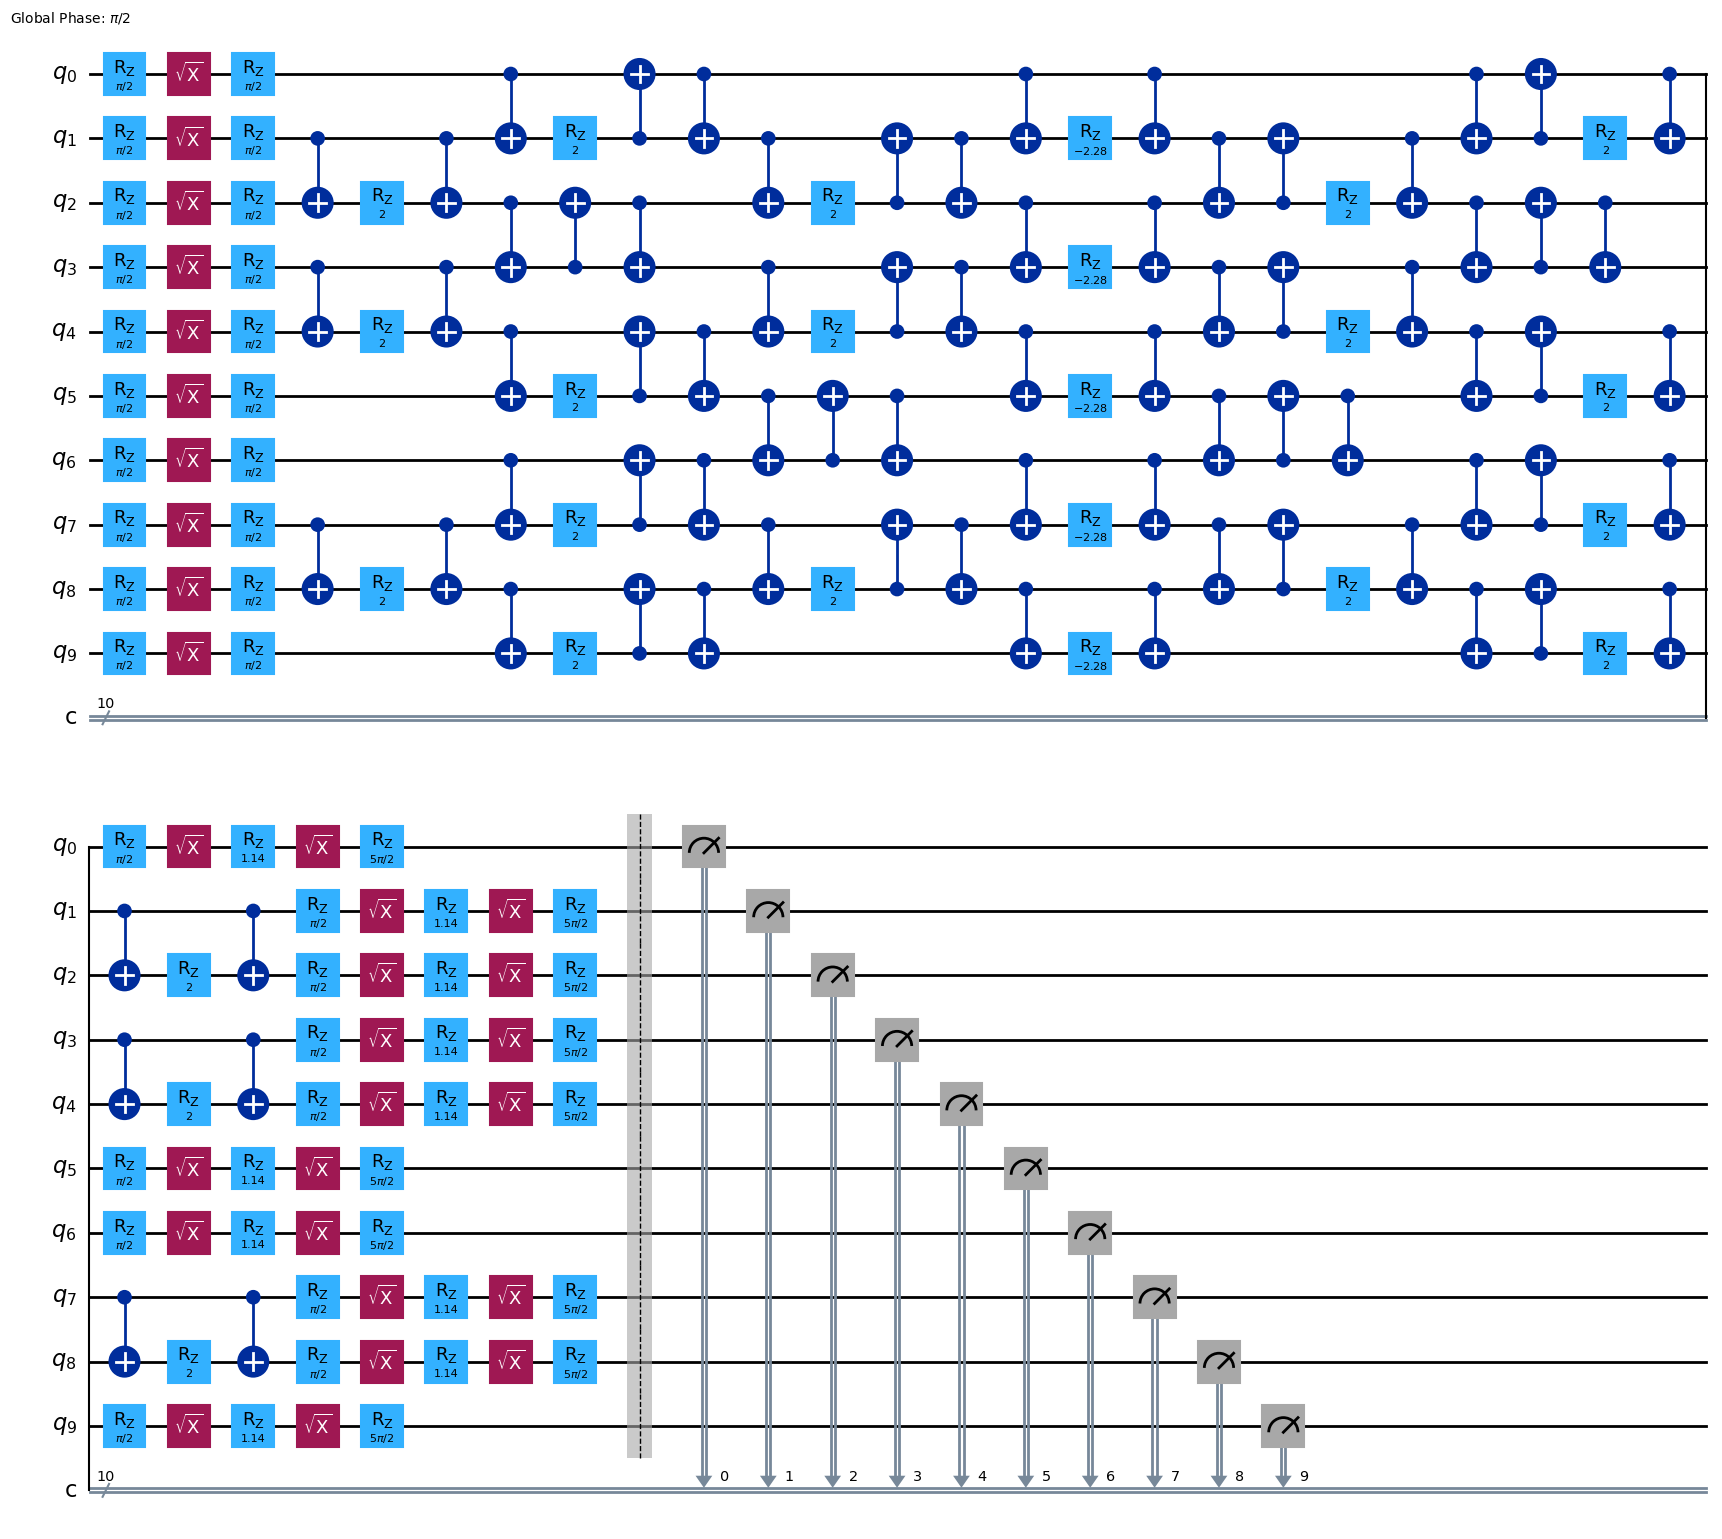

In [14]:
# Optional custom transpilation steps go here (to match specific hardware)
from qiskit import transpile

basis_gates = ["rz", "sx", "x", "cx"]
#
# Now transpile to sx, rz, x, cx basis
t_final_circuit = transpile(final_circuit, basis_gates=basis_gates, optimization_level=2)
t_final_circuit.draw("mpl")